# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling2D, concatenate, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('DB2/DB2_S1_image_200_0.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  
file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
data  = np.expand_dims(data, axis=2)
label = convert_to_one_hot(label,49).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

/home/malele/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train shape: (9531, 200, 1, 12)
Y_train shape: (9531, 49)
X_test shape: (2383, 200, 1, 12)
Y_test shape: (2383, 49)


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


# 建立模型

In [3]:
def CNN(input_shape=(200,1,12), classes=49): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32,kernel_size=(20,1),strides=(1,1),padding='same',activation='relu',name='conv1')(X_input)
    X = MaxPooling2D(pool_size=(10,1), strides=(10,1), name='pool1')(X)
    
    X = Conv2D(filters=64,kernel_size=(6,1),strides=(1,1),padding='same',activation='relu',name='conv2')(X)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), name='pool2')(X)
    
    X = Conv2D(filters=128,kernel_size=(3,1),strides=(1,1),padding='same',activation='relu',name='conv3')(X)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), name='pool3')(X)
    
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model
model = CNN(input_shape = (200, 1, 12), classes = 49)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1, 12)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 200, 1, 32)        7712      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 20, 1, 32)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 20, 1, 64)         12352     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 10, 1, 64)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 1, 128)        24704     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 5, 1, 128)         0         
__________

# 训练原始数据

In [4]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, 
            validation_data=(X_test, Y_test),callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))


end = time.time()
print("time:",end-start)

Train on 9531 samples, validate on 2383 samples
Epoch 1/100
9531/9531 [==============================] - 3s 346us/step - loss: 3.8329 - acc: 0.0358 - val_loss: 3.6237 - val_acc: 0.0965
Epoch 2/100
9531/9531 [==============================] - 3s 268us/step - loss: 3.2860 - acc: 0.1165 - val_loss: 2.7387 - val_acc: 0.2262
Epoch 3/100
9531/9531 [==============================] - 2s 245us/step - loss: 2.6640 - acc: 0.2200 - val_loss: 2.2518 - val_acc: 0.3139
Epoch 4/100
9531/9531 [==============================] - 2s 241us/step - loss: 2.3472 - acc: 0.2844 - val_loss: 2.0594 - val_acc: 0.3747
Epoch 5/100
9531/9531 [==============================] - 2s 247us/step - loss: 2.1294 - acc: 0.3454 - val_loss: 1.8353 - val_acc: 0.4285
Epoch 6/100
9531/9531 [==============================] - 2s 252us/step - loss: 1.9504 - acc: 0.3962 - val_loss: 1.6872 - val_acc: 0.4885
Epoch 7/100
9531/9531 [==============================] - 2s 252us/step - loss: 1.7887 - acc: 0.4443 - val_loss: 1.5712 - val_acc: 

9531/9531 [==============================] - 2s 242us/step - loss: 0.5589 - acc: 0.8071 - val_loss: 0.9513 - val_acc: 0.7260
Epoch 61/100
9531/9531 [==============================] - 2s 234us/step - loss: 0.5512 - acc: 0.8122 - val_loss: 0.8974 - val_acc: 0.7335
Epoch 62/100
9531/9531 [==============================] - 2s 235us/step - loss: 0.5820 - acc: 0.8018 - val_loss: 0.9391 - val_acc: 0.7289
Epoch 63/100
9531/9531 [==============================] - 2s 230us/step - loss: 0.5596 - acc: 0.8103 - val_loss: 0.9117 - val_acc: 0.7419
Epoch 64/100
9531/9531 [==============================] - 2s 234us/step - loss: 0.5520 - acc: 0.8117 - val_loss: 0.9592 - val_acc: 0.7302
Epoch 65/100
9531/9531 [==============================] - 2s 253us/step - loss: 0.5291 - acc: 0.8169 - val_loss: 0.8936 - val_acc: 0.7289
Epoch 66/100
9531/9531 [==============================] - 3s 268us/step - loss: 0.5469 - acc: 0.8132 - val_loss: 0.9768 - val_acc: 0.7172
Epoch 67/100
9531/9531 [=======================

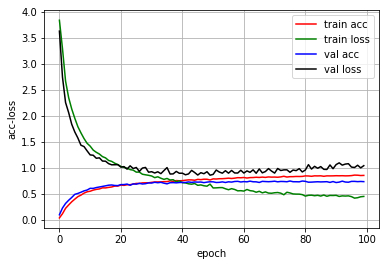

In [5]:
history.loss_plot('epoch')